In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,KernelPCA
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering

import random

In [2]:
dataset = boston_dataset = datasets.load_boston()

X_df = pd.DataFrame(boston_dataset.data)
X_fn = boston_dataset.feature_names
X_df.columns = X_fn

X_df = X_df.drop(['CHAS'], axis = 1)

y_df = pd.DataFrame(boston_dataset.target)
y_df.columns = ['MEDV']

# 1. Data Preprocessing

In [3]:
scaler = StandardScaler()

def get_scaled_df(X_df,scaler):
    
    X_scaled = scaler.fit_transform(X_df.values)

    X_df_scaled = pd.DataFrame(X_scaled)

    X_df_scaled.columns = X_df.columns
    
    return X_df_scaled

X_scaled = get_scaled_df(X_df,scaler)
y = y_df

<AxesSubplot:>

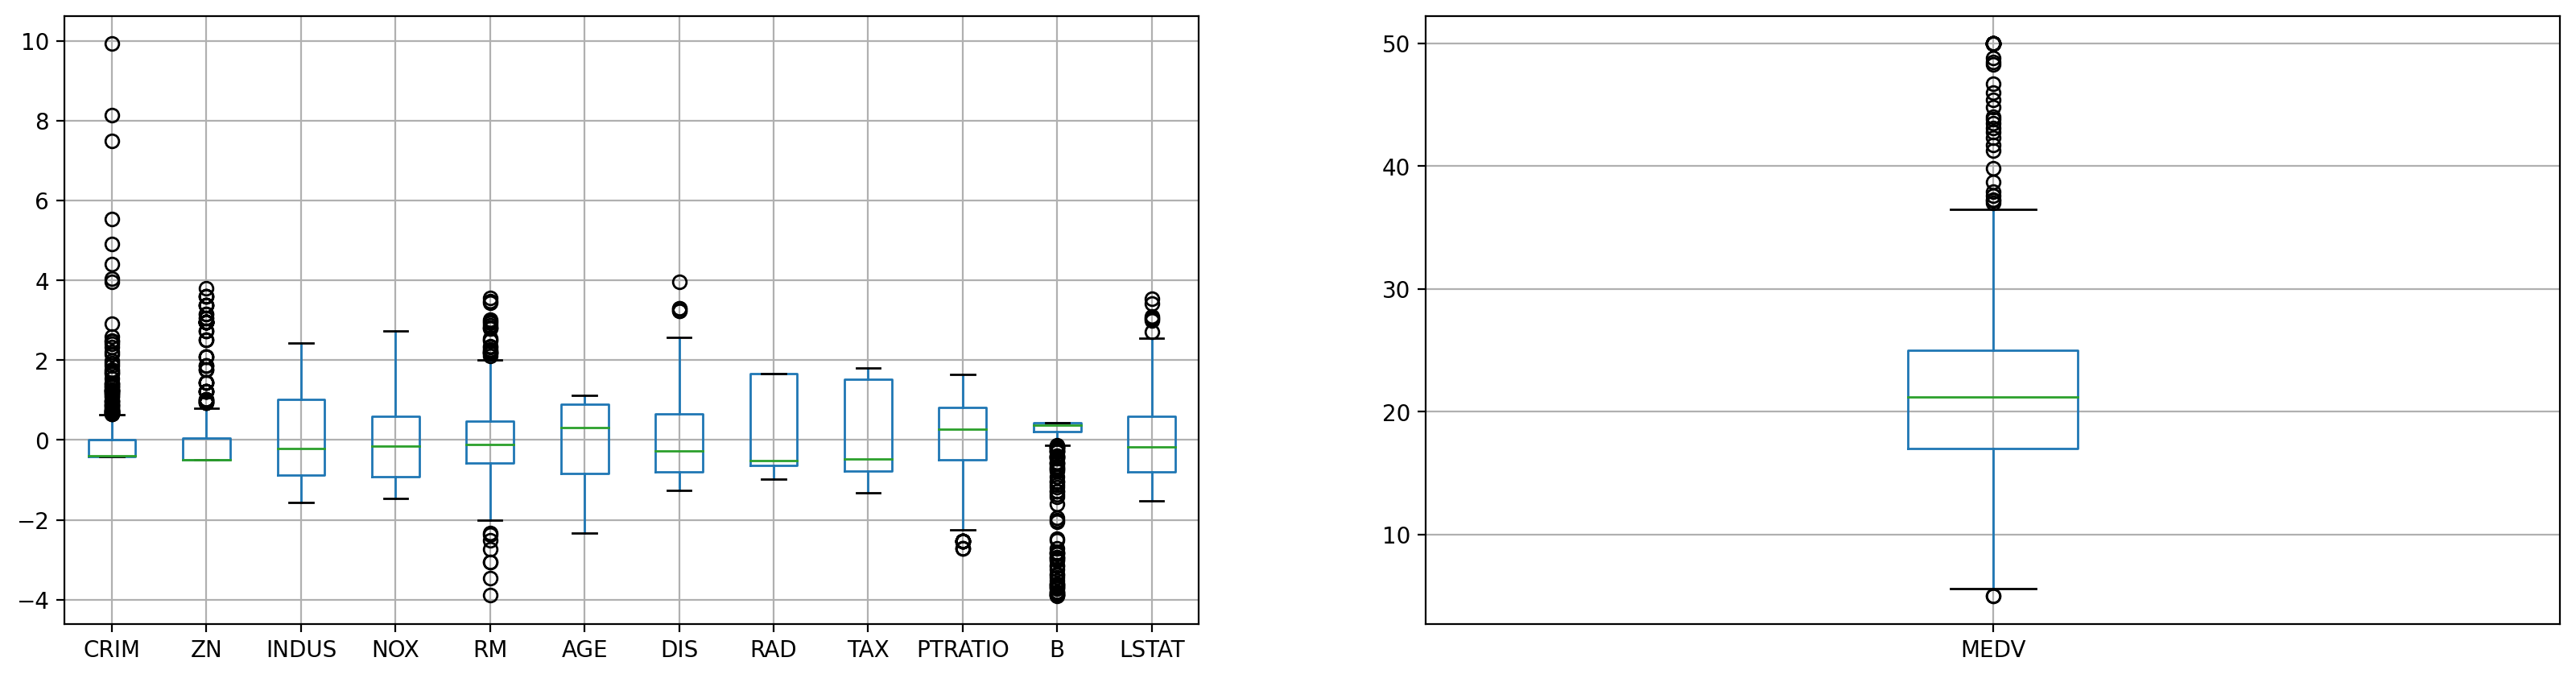

In [4]:
# data distribution after scaling

fig = plt.figure(figsize = (20,5), dpi = 200)

ax = fig.add_subplot(1,2,1)
X_scaled.boxplot()

ax = fig.add_subplot(1,2,2)
y.boxplot()

In [5]:
def get_remove_outliers(X_df,y_df,q):
    
    data = np.column_stack((X_df.values,y_df.values))
    
    for j in range(data.shape[1]):
    
        median = np.median(data[:,j])
        
        upper_quartile = np.percentile(data[:,j], 75)
        lower_quartile = np.percentile(data[:,j], 25)

        iqr = upper_quartile - lower_quartile
        upper_whisker = (data[:,j][data[:,j] <= upper_quartile + q * iqr]).max()
        lower_whisker = (data[:,j][data[:,j] >= lower_quartile - q * iqr]).min()
        
        data_clean = data[data[:,j] <= upper_whisker]
        data_clean = data_clean[data_clean[:,j] >= lower_whisker]
        
        data = data_clean
        
        
    X_df_clean = pd.DataFrame(data_clean[:,:data_clean.shape[1] - 1])
    X_df_clean.columns = X_df.columns
    
    y_df_clean = pd.DataFrame(data_clean[:,data_clean.shape[1] - 1])
    y_df_clean.columns = y_df.columns
    
    return X_df_clean,y_df_clean

In [6]:
q = 3

X_scaled_clean, y_clean = get_remove_outliers(X_scaled,y, q)

fraction_removed_outliers =  1 - X_scaled_clean.shape[0] / X_scaled.shape[0]

print('Removed {:.1f} % data'.format(fraction_removed_outliers * 100))

Removed 33.8 % data


Text(0.5, 1.0, 'y after removing outliers')

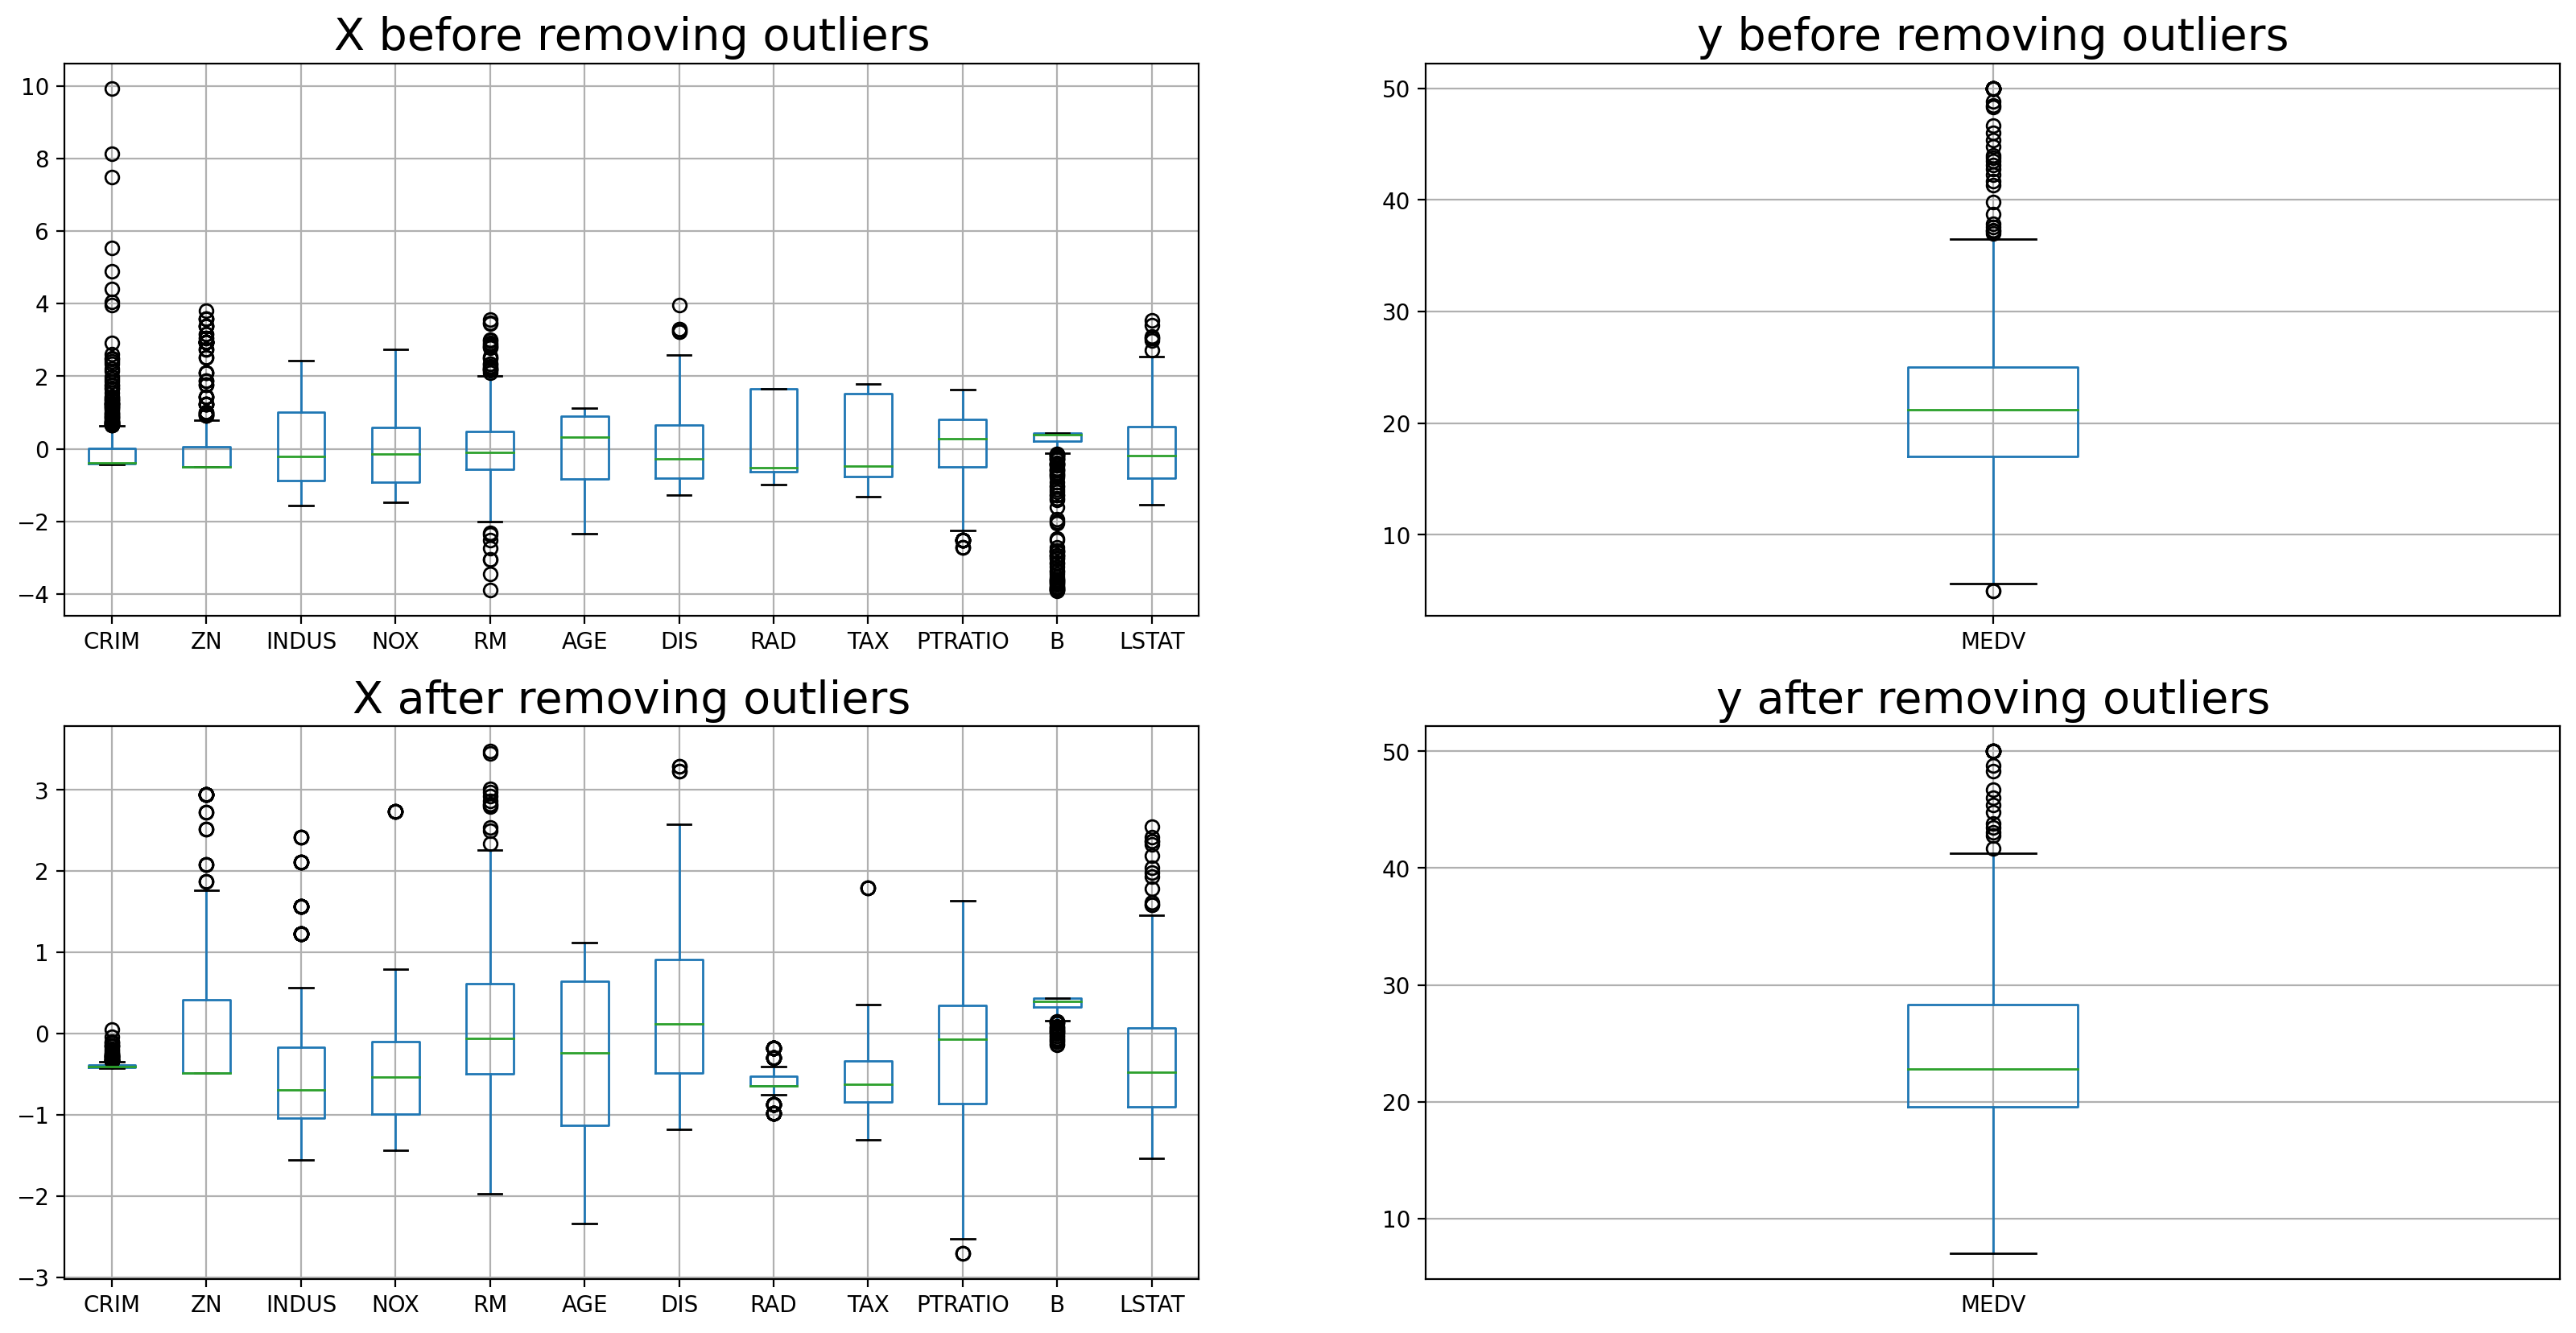

In [7]:
# data distribution after removing outliers

fig = plt.figure(figsize = (20,10), dpi = 200)

ax = fig.add_subplot(2,2,1)
X_scaled.boxplot()
plt.title('X before removing outliers', fontsize = 20)

ax = fig.add_subplot(2,2,2)
y.boxplot()
plt.title('y before removing outliers', fontsize = 20)

ax = fig.add_subplot(2,2,3)
X_scaled_clean.boxplot()
plt.title('X after removing outliers', fontsize = 20)

ax = fig.add_subplot(2,2,4)
y_clean.boxplot()
plt.title('y after removing outliers', fontsize = 20)

# 2. k-Means

**Explaination of the k-means++ algorithm (fix to the random initialization of the centroids**

https://www.youtube.com/watch?v=HatwtJSsj5Q

In [8]:
# n_clusters: number of clusters we want to consider in partitioning the dataset.
            # in this example we set any value we like, but the appropriate way to
            # select the number of clusters is to evaluate the within cluster squared sum (WCSS)
            # which is the sum over all the clusters of the sum over all the samples in a cluster
            # of the squared distance between the samples.
            
            # ex.: 2 cluster (1 (with 3 observations a,b,c) and 2 (with 4 observactions d,e,f)
            
            # WCSS_1 = (d_ab**2 + d_ac**2 + d_bc**2) / 3
            
            # WCSS_2 = (d_de**2 + d_df**2 + d_ef**2) / 3
            
            # WCSS = WCSS_2 + WCSS_3
            
            # increasing the number of clusters, WCSS drop, and the number of clusters to pick is 
            # the one which leads to a plateau in the WCSS decrease (elbow method)
            
        
n_clusters = 4

# init: initialization of the clusters centroids at the first iteration of the k-means algorithm
        
        # k-means++: fix the disadvantage of a random initialization, that is the sensitivity of 
                    # the final centroids respect to the initialization >>> a bad random initialization 
                    # could lead to a bad clustering. 
                
                    # k-means ++ assigns the initial K (K: n_clusters) clusters centroids 
                    # to the observations in the dataset
                    
                    # 1) the first centroid is assigned to a random observations
                    
                    # 2) the remaining K-1 clusters are assigned to other observations
                    #    where the probability of an observation to be declared as cluster
                    #    is proportional to the squared distance from the centroid of the 
                    #    cluster to which the observation belongs
                    #    practically speaking, the centroids will correspond to the data which are
                    #    more spread in the dataset
                    #
                    # 3) the k-means algorithm is repeated n_init times, where all the time the first
                    #    centroid correspond to a different random observation 
                    #    (see the link above for the explaination of how k-means ++ works)
                
        
        # random: random initialization of the centroids. Problematic because a random bad initialization
                 # leads to a bad clustering (fixed with k-means++)
            
init = 'k-means++'

# n_init: the k-means algorithm is run n_init times, where all the time the initialization of the centroids changes.
          # since a different initialization leads to a different clustering, the best clustering is chosen as 
          # the one with lowest WCSS
          # why the initialization is different all the times?
          # k-means++: a different random observation is set as centroid all the times
          # random:  initialization changes all the time with random assignment of centroids
            
n_init = 10

# max_iter: maximum number of centroid adjustment that can be performed by the algorithm in a single run

max_iter = 300
           
#def get_kmeans(X, n_cluster)

kmeans = KMeans(n_clusters = n_clusters, init = init, max_iter = max_iter)

kmeans.fit(X_scaled_clean)

KMeans(n_clusters=4)

In [47]:
def get_kmeans(X,n_clusters):
    
    kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', n_init = 10)

    kmeans.fit(X)
    
    clusters = []
    
    for cluster_index in range(n_clusters):
        
        cluster = X[kmeans.predict(X) == cluster_index].values
        
        centroid = kmeans.cluster_centers_[cluster_index].reshape(1,-1)
                
        cluster = np.concatenate([centroid, cluster], axis = 0)
        
        cluster = pd.DataFrame(cluster)
        
        cluster.columns = X.columns
        
        clusters.append(cluster)
        
        wcss = kmeans.inertia_
    
    return clusters, wcss


def plot_WCSS(X,n_clusters):
    
    WCSS = []
    
    for n in n_clusters:
        
        _,wcss = get_kmeans(X,n)
        
        WCSS.append(wcss)
        
    fig = plt.figure(figsize = (10,5))
    
    plt.plot(n_clusters,WCSS/np.max(WCSS),'bo-')
    plt.xlabel('N. cluster')
    plt.ylabel('Normalized WCSS')
    

def plot_clusters(X, n_clusters,hor,ver):
    
    clusters,_ = get_kmeans(X, n_clusters)
    

 
    fig = plt.figure(figsize = (10,10))
    
    for cluster_index in range(n_clusters):
        
        cluster = clusters[cluster_index].values
    
        plt.scatter(cluster[0][hor - 1], cluster[0][ver - 1],
            c = 'r',
            marker ='*', 
           linewidths = 5)
        
        
        if clusters[cluster_index][1:].shape[0] > 1:
        
            plt.scatter(cluster[1:,hor - 1], cluster[1:,ver - 1])
        
            plt.xlabel(X.columns[hor - 1])
            plt.ylabel(X.columns[ver - 1])
            
    
        

    
    

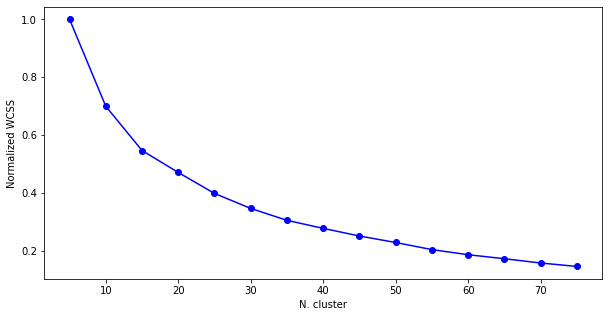

In [48]:
n_clusters = np.arange(5,80,5)

plot_WCSS(X_scaled_clean,n_clusters)

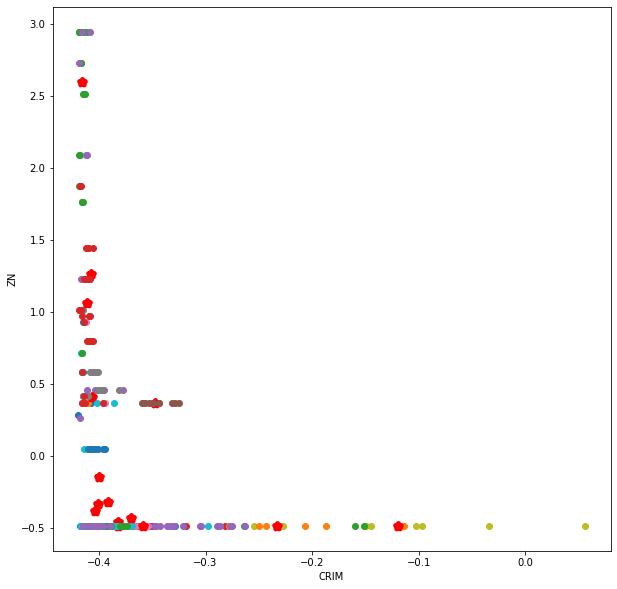

In [49]:
n_clusters = 15


hor = 1

ver = 2


plot_clusters(X_scaled_clean,n_clusters, hor,ver)

# 2.1 k-Means  applied to PCA dataset

In [50]:
def get_variance(X):
    
    variance = 0
    
    for i in range(X.shape[0]):
        
        for j in range(X.shape[1]):
            
            variance += X.values[i,j]**2
            
    variance /= X.shape[0]
            
    return variance

def get_kernel_pca(X,n_components, kernel, degree):
    
    pca = KernelPCA(n_components = n_components, kernel = kernel, degree = degree)

    pca.fit(X)

    X_pca = pca.fit_transform(X)

    X_pca = pd.DataFrame(X_pca)
    
    fn = []
    
    for i in range(n_components):
        
        fn.append('component ' + str(i + 1))
        
    X_pca.columns = fn
    

    pve = get_variance(X_pca)/get_variance(X) 
    

    print('Cumulative PVE: {:.1f} %'.format(pve*100))
    
    return X_pca, pca, pve


def get_scree_plot_kernel_pca(X,n_components,kernel,degree):
    
    cumulative_pve = np.zeros((len(n_components)))
    
    
    for i,n in enumerate(n_components):
        
        _, _, pve = get_kernel_pca(X,n, kernel, degree)

        cumulative_pve[i] += 100 * pve
        
    fig = plt.figure(figsize = (5,5))
        
    plt.plot(n_components, cumulative_pve,'bo-')
    plt.xlabel('N. components')
    plt.ylabel('Cumulative PVE')
    

Cumulative PVE: 2.4 %
Cumulative PVE: 5.4 %
Cumulative PVE: 6.1 %
Cumulative PVE: 6.4 %
Cumulative PVE: 6.6 %
Cumulative PVE: 6.6 %
Cumulative PVE: 6.7 %
Cumulative PVE: 6.7 %
Cumulative PVE: 6.8 %
Cumulative PVE: 6.8 %


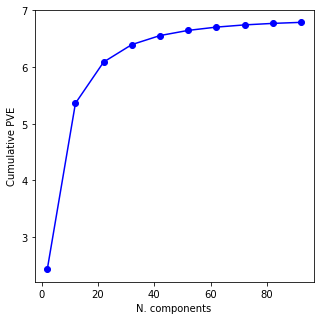

In [51]:
# apply kernel pca and find the optimal configuration

n_components = np.arange(2,100,10)

kernel = 'rbf'

degree = 3

get_scree_plot_kernel_pca(X_scaled_clean,n_components,kernel,degree)

In [52]:
X_kernel_pca,_,_ = get_kernel_pca(X_scaled_clean, n_components = 15, kernel = 'rbf',degree = 3)

Cumulative PVE: 5.7 %


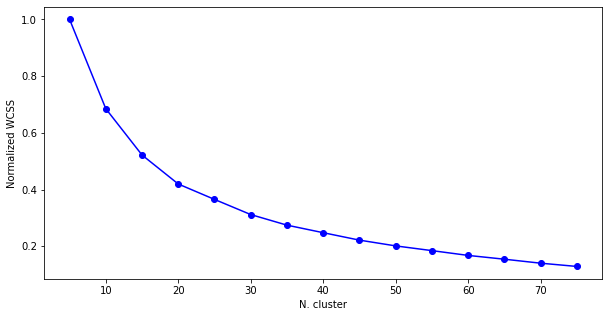

In [53]:
# find the optimal number of clusters to partition the pca dataset

n_clusters = np.arange(5,80,5)

plot_WCSS(X_kernel_pca,n_clusters)

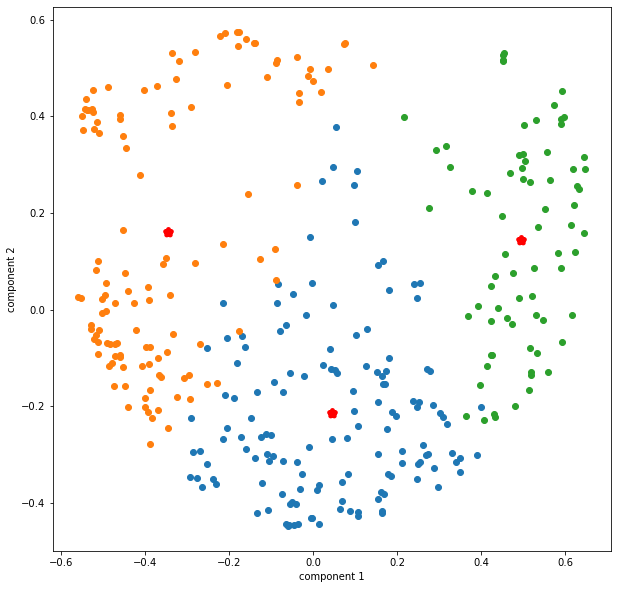

In [54]:
n_clusters = 


hor = 1

ver = 2

plot_clusters(X_kernel_pca,n_clusters, hor,ver)

In [55]:
clusters_kernel_pca,_ = get_kmeans(X_pca, n_clusters = 3)

In [61]:
clusters_kernel_pca[2]

,component 1,component 2,component 3,component 4,component 5,component 6,component 7,component 8,component 9,component 10,component 11,component 12,component 13,component 14,component 15
0,-0.396466,0.107845,-0.110123,-0.013759,-0.008130,-0.026990,0.004990,-0.015909,0.017863,-0.006767,-0.012024,-0.007492,-0.019912,0.013569,-0.003654
1,-0.155787,0.240412,-0.178083,0.487613,-0.024171,0.233105,-0.045974,-0.259838,-0.082846,0.138017,-0.138635,0.065428,-0.084013,0.046118,0.057920
2,-0.383874,-0.224472,-0.073368,-0.149824,-0.284935,0.082666,0.065690,0.071048,-0.009451,-0.059903,0.009721,-0.189942,0.001365,-0.017580,-0.012092
3,-0.440710,-0.202370,-0.163371,-0.071043,-0.279745,0.068788,0.092875,-0.011014,-0.105195,-0.017993,-0.012668,-0.143484,-0.046020,0.005545,-0.010863
4,-0.388145,-0.277292,-0.165739,-0.118267,-0.156649,0.001030,0.193302,0.059422,-0.086608,-0.025056,0.019300,-0.122975,0.015380,-0.047044,0.022215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,-0.396574,-0.077034,0.046315,-0.355009,-0.099684,-0.092566,0.064354,0.101422,0.024907,0.036389,-0.027704,-0.132420,0.079601,-0.012822,-0.144870
104,-0.471433,-0.070615,-0.047864,-0.282245,-0.117281,-0.128245,0.100210,0.115092,0.013900,0.011327,0.016719,-0.142000,0.105760,0.011533,-0.103835
105,-0.356947,0.093598,0.187379,-0.386737,-0.178916,-0.011502,-0.007916,0.149184,0.089022,-0.000762,-0.079940,-0.122407,0.106335,-0.028103,-0.166616
106,-0.391827,0.047482,0.142200,-0.370256,-0.185711,-0.034347,-0.002167,0.148238,0.085526,-0.004930,-0.053367,-0.145774,0.104560,-0.011707,-0.158522


# 3. Hierarchical Clustering

In [112]:
def get_hierarchical_clustering(X,n_clusters, hor,vert):
    
    # Normalization is the process of scaling individual samples to have unit norm. 
    # This process can be useful if you plan to use a quadratic form such as 
    # the dot-product or any other kernel to quantify the similarity of any pair of samples.

    X_norm = normalize(X)
    
    X_norm = X.values
    
    plt.figure(figsize=(20, 20),dpi = 100)
    
    dendogram = shc.dendrogram(shc.linkage(X_norm, method = 'ward'))
    
    plt.ylabel('Euclidean distances')
    plt.title("Dendrograms")  
    
    hc = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'euclidean', linkage = 'ward')
    
    y_hc = hc.fit_predict(X_norm)
    
    plt.figure(figsize=(20, 20), dpi = 100)  
    
    for i in range(n_clusters):
        
        plt.scatter(X_norm[y_hc == i, hor - 1], X_norm[y_hc == i, vert - 1], s = 100, label = 'Cluster {}'.format(i + 1))
        plt.xlabel(X.columns[hor - 1])
        plt.ylabel(X.columns[vert - 1])

        
    
    
    
    
    

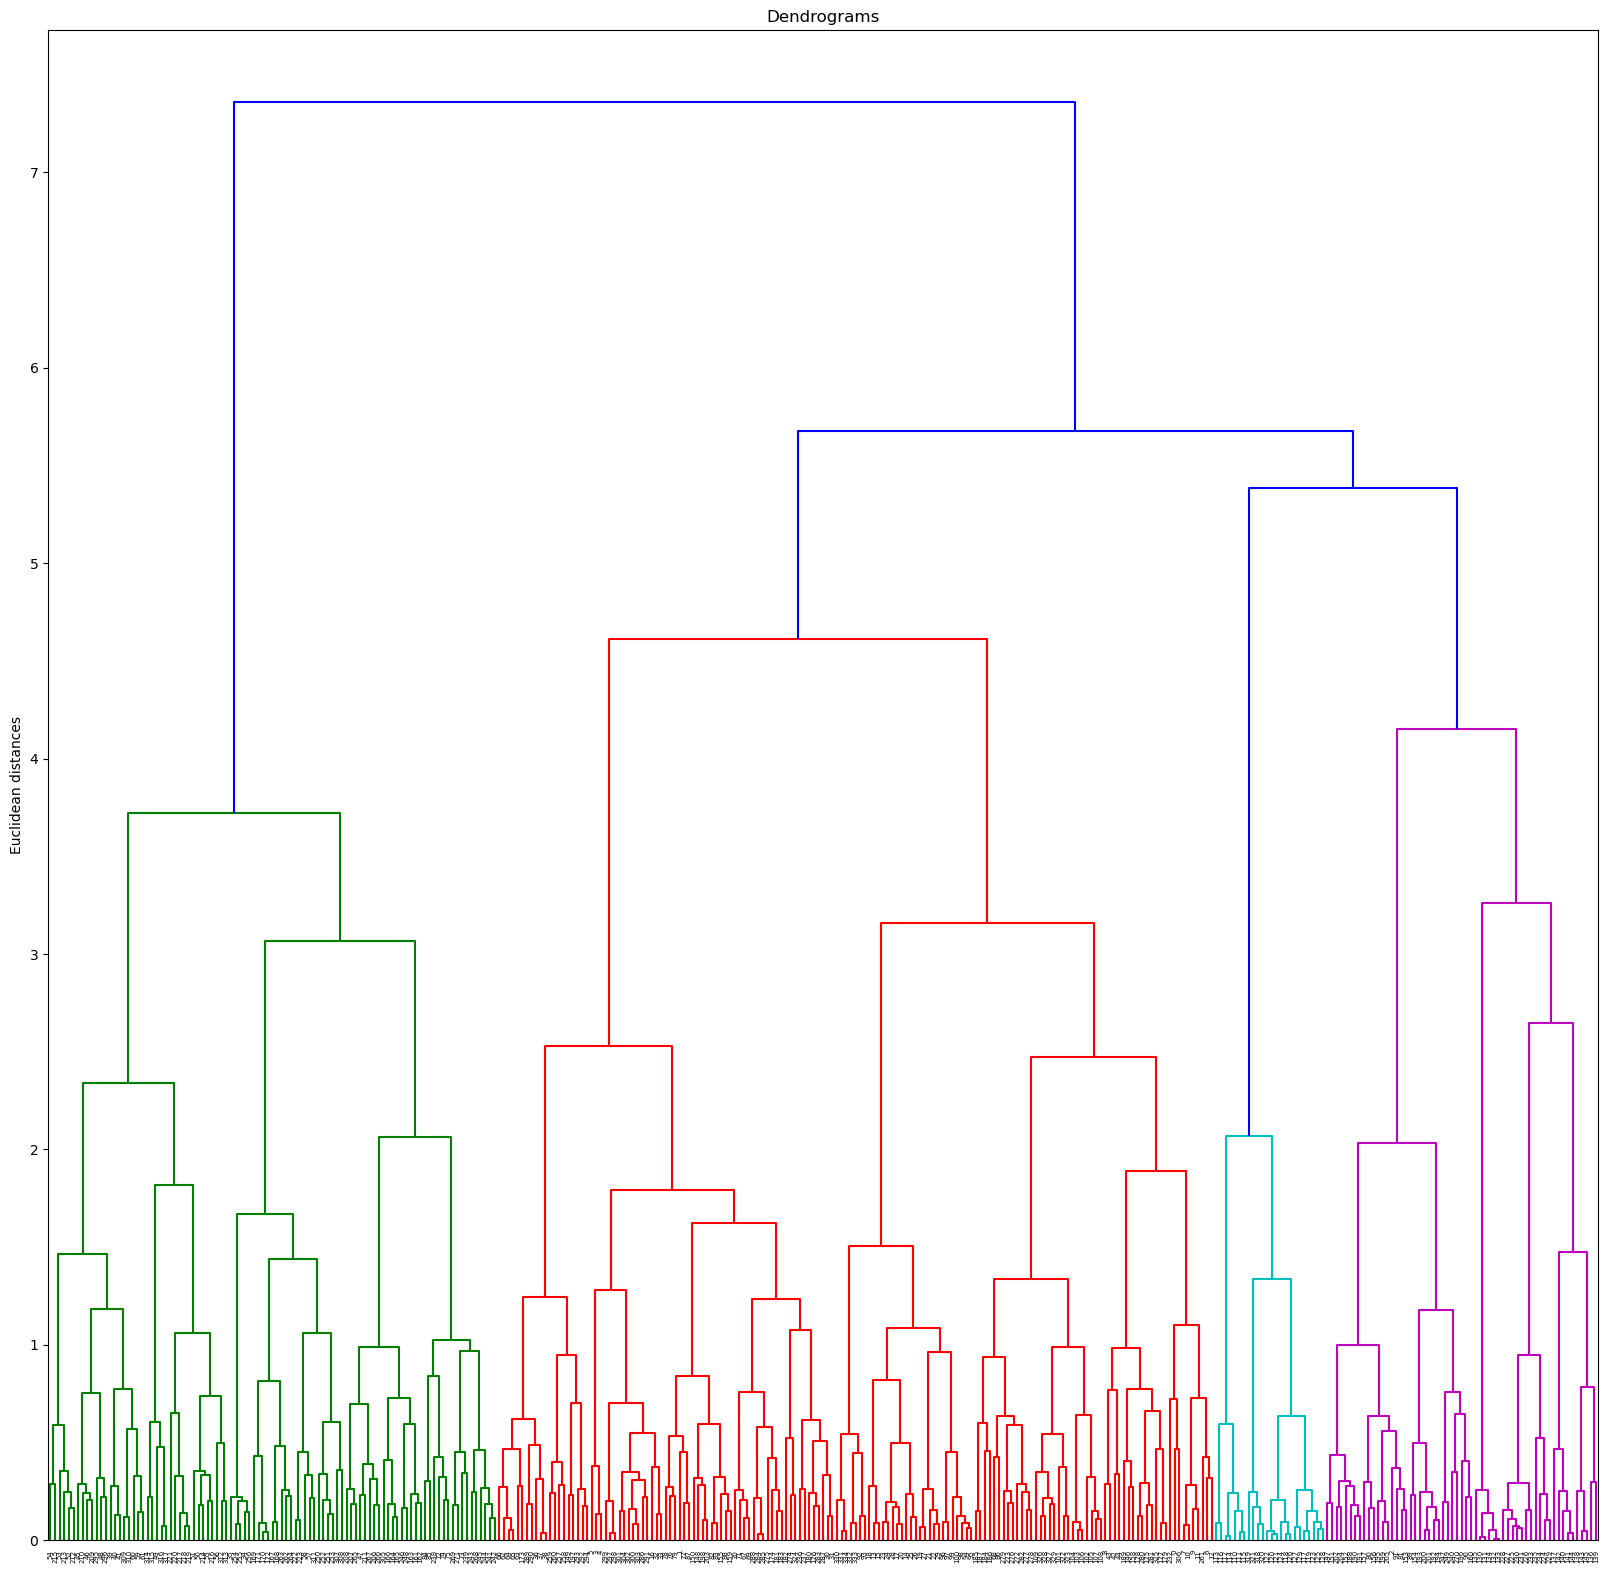

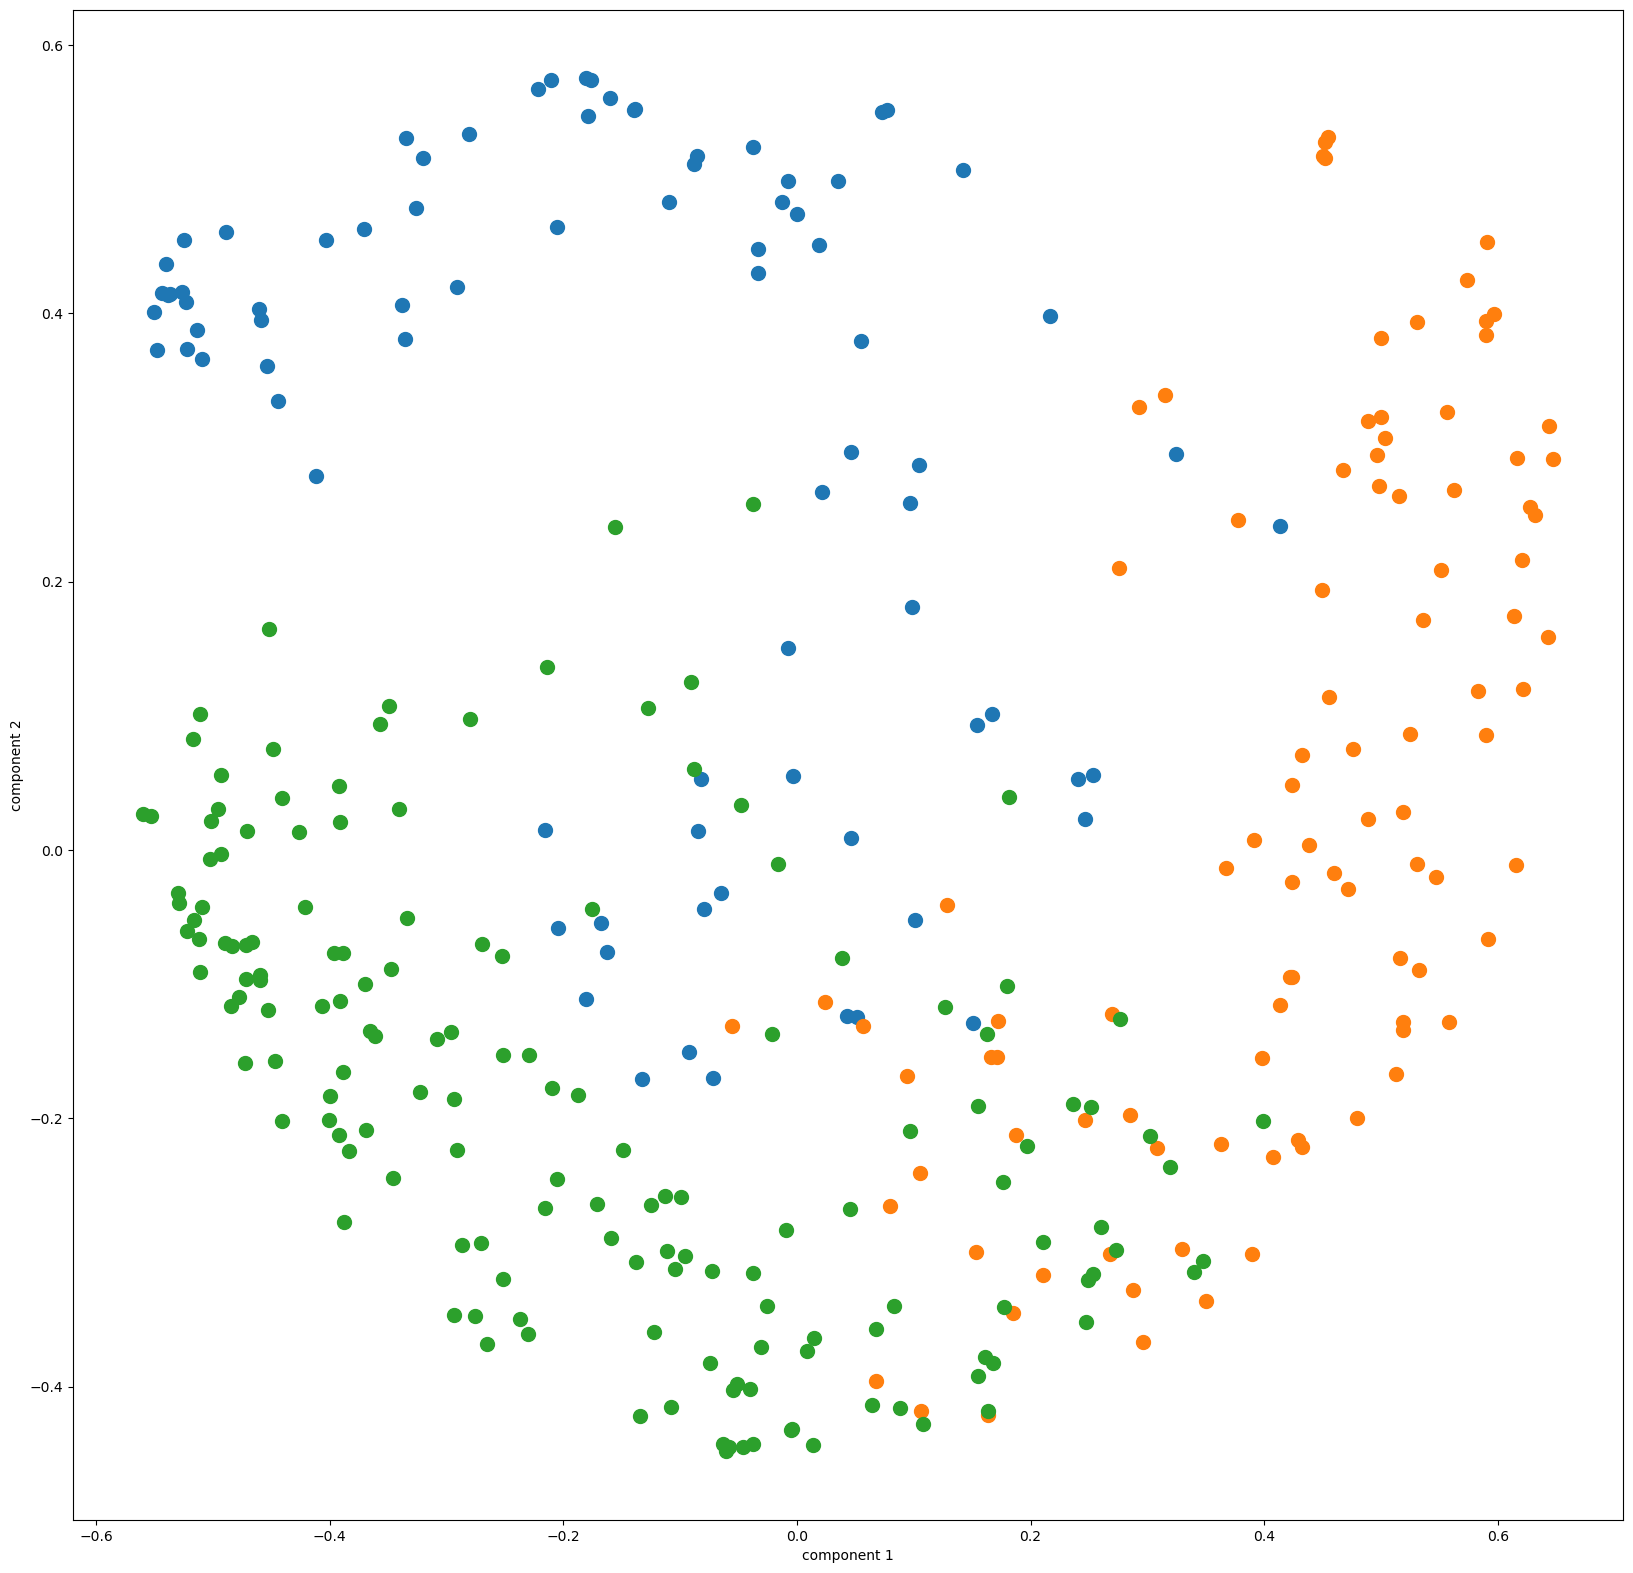

In [113]:
n_clusters = 3

hor = 1
vert = 2

get_hierarchical_clustering(X_kernel_pca, n_clusters, hor, vert)

**Example: dendogram fitted on kernel pca dataser**

d: max distance between samples to consider in the formation of clusters

1) d = 9: 2 vertical lines are crossed (2 blue) >>> 2 clusters

2) d = 8: 3 vertical lines are crossed (3 blue) >>> 3 clusters

3) d = 7: 4 vertical lines are crossed (2 blue, 2 cyan) >>> 4 clusters

4) d = 6: 5 vertical lines are crossed (2 green,1 blue, 2 cyan) >>> 5 clusters